In [1]:
from math import pi, sqrt, cosh, exp, floor, tanh, log, sinh, cosh
import numpy as np
from numpy import linspace, logspace
from scipy.optimize import fsolve
from scipy.integrate import quad

import matplotlib.pyplot as plt
#makes plots bigger and use Latex fonts
from matplotlib import rcParams
rcParams["figure.dpi"]=600
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2.5

In [2]:
HBARC = 197.3269718
NEUTRON_MASS = 939.5653 / HBARC
PROTON_MASS = 938.272 / HBARC
NUCLEON_MASS = 2 * NEUTRON_MASS * PROTON_MASS / (NEUTRON_MASS + PROTON_MASS)
MUON_MASS = 105.7 / HBARC
ELECTRON_MASS = 0.511 / HBARC
GA = 1.267
MEVFM3_TO_GCM3 = 1.78e12
FM4_TO_DYNECM2 = 3.16e35
G_TO_FM = 7.69**2 / 10**16 / HBARC**2

COS_TC = sqrt(0.95)
GF = (HBARC / 292800)**2
GN = -1.913 * 2
GP = 3.586 + 2

def gntilde(eb, t):
    return GF**2 * COS_TC**2 * eb / (4 * pi * cosh(GN * eb / (4 * NUCLEON_MASS * t)))
def gptilde(eb, t):
    return GF**2 * COS_TC**2 * eb / (4 * pi * cosh(GP * eb / (4 * NUCLEON_MASS * t)))

def fermi_dirac(x):
    x = np.asarray(x)  # Ensure input is an array if it's not already
    result = np.empty_like(x, dtype=np.float64)
    
    # For x > 0, use the identity: 1 / (exp(x) + 1) = exp(-x) / (1 + exp(-x))
    pos_mask = x > 0
    result[pos_mask] = np.exp(-x[pos_mask]) / (1 + np.exp(-x[pos_mask]))
    
    # For x <= 0, compute directly: 1 / (exp(x) + 1)
    result[~pos_mask] = 1 / (np.exp(x[~pos_mask]) + 1)
    
    return result

def nfd(e, mu, t):
    return fermi_dirac((e - mu) / t)
    #if (e - mu) / t > 20:
    #    return 0
    #elif (e - mu) / t < -20:
    #    return 1
    #return 1 / (np.exp((e - mu) / t) + 1)

In [55]:
def electron_energy(eb, n, kz):
    return np.sqrt(2 * n * eb + kz**2 + ELECTRON_MASS**2)

def log_electron_density(mu, eb, t):
    if mu < 0:
        max_ll = 10 * floor(t**2 / (2 * eb))
    else:
        max_ll = 10 * floor((t + mu)**2 / (2 * eb))

    pos_ll = linspace(1, max_ll, max_ll)
    return log(quad(lambda kz: eb / (2 * pi**2) * (nfd(np.sqrt(kz**2 + ELECTRON_MASS**2), mu, t) + 2 * np.sum(nfd(electron_energy(eb, pos_ll, kz), mu, t))), 0, max((20 * t, 20 * (t + mu), 50 * sqrt(t * 2 * eb))))[0])

def mue_solver(ne, eb, t):
    return fsolve(lambda mu: log(ne) - log_electron_density(mu, eb, t), 5 / HBARC)[0]

def mue_solver_zero(ne, t):
    return fsolve(lambda mu: log(ne) - log(quad(lambda k: k**2 / (pi**2 * (np.exp((k - mu) / t) + 1)), 0, max((20 * t, 20 * (t + mu))))[0]), 20 / HBARC)[0]

In [4]:
#if ne is 0, set ne0 to 1
def mat_elt(sp, sn, ct_nu, ne0 = 0):
    if sp == 1 and sn == 1:
        return 2 * (1 + GA)**2 * (1 + ct_nu) + 2 * (1 - GA)**2 * (1 - ct_nu) * (1 - ne0)
    elif sp == 1 and sn == -1:
        return 8 * GA**2 * (1 - ct_nu)
    elif sp == -1 and sn == 1:
        return 8 * GA**2 * (1 + ct_nu) * (1 - ne0)
    elif sp == -1 and sn == -1:
        return 2 * (1 - GA)**2 * (1 + ct_nu) + 2 * (1 + GA)**2 * (1 - ct_nu) * (1 - ne0)
    else:
        print('invalid spin')
        return 0

In [64]:
def nun_opacity_high(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + (GP - 2) * sp * eb / (4 * NUCLEON_MASS)
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, 1) * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density * exp(GP * sp * ebmt / 2) * exp(-ebmt / 2) * (pi / mt)**(3 / 2) * sinh(ebmt / 2) / cosh(GP * ebmt / 4) * 2 / (ebmt + 1 - exp(-ebmt))
                * exp(- knu**2 * (1 - ct_nu**2) / (2 * eb + 2 * mt) * eb * exp(-ebmt) / (eb + mt * (1 - exp(-ebmt))) - knu**2 * ct_nu**2 / (4 * mt)))
    return result

def nun_opacity_med(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS)
            v_tilde = max((e0pl**2 / eb, 1))
            if v_tilde == 1:
                ne0 = 1
            else:
                ne0 = 0
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, ne0) * v_tilde * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density * exp(GP * sp * ebmt / 2) * (pi / mt)**(3 / 2) * sinh(ebmt / 2) / cosh(GP * ebmt / 4) / ebmt * exp(- knu**2 / (4 * mt)))
    return result

def nun_opacity_low(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS)
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu) * e0pl**2 / eb * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density / 2 * exp(GP * sp * ebmt / 2) * (pi / mt)**(3 / 2) / cosh(GP * ebmt / 4) * exp(- knu**2 / (4 * mt)))
    return result

def nun_opacity_zero(nb, yp, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver_zero(prot_density, t)
    #print(mue)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS
            result += GF**2 * COS_TC**2 / (4 * pi) * neut_density / 2 * mat_elt(sp, sn, ct_nu) * e0pl**2 * (1 - nfd(e0pl, mue, t)) * (
                1 - prot_density / 2 * (pi / mt)**(3 / 2) * exp(- knu**2 / (4 * mt)))
    return result

In [203]:
nun_opacity_high(0.00016, 0.25, 10**17 * G_TO_FM, 1 / HBARC, 10 / HBARC, 0) * 10**13

3.671899059497774e-06

In [28]:
nun_opacity_med(0.00016, 0.25, 10**17 * G_TO_FM, 1 / HBARC, 10 / HBARC, 0) * 10**13

3.863293956972638e-06

3.6e-06

Text(0.5, 1.0, '$B = 10^{17}$ G (strong-ish at this T), $T = 10$ MeV')

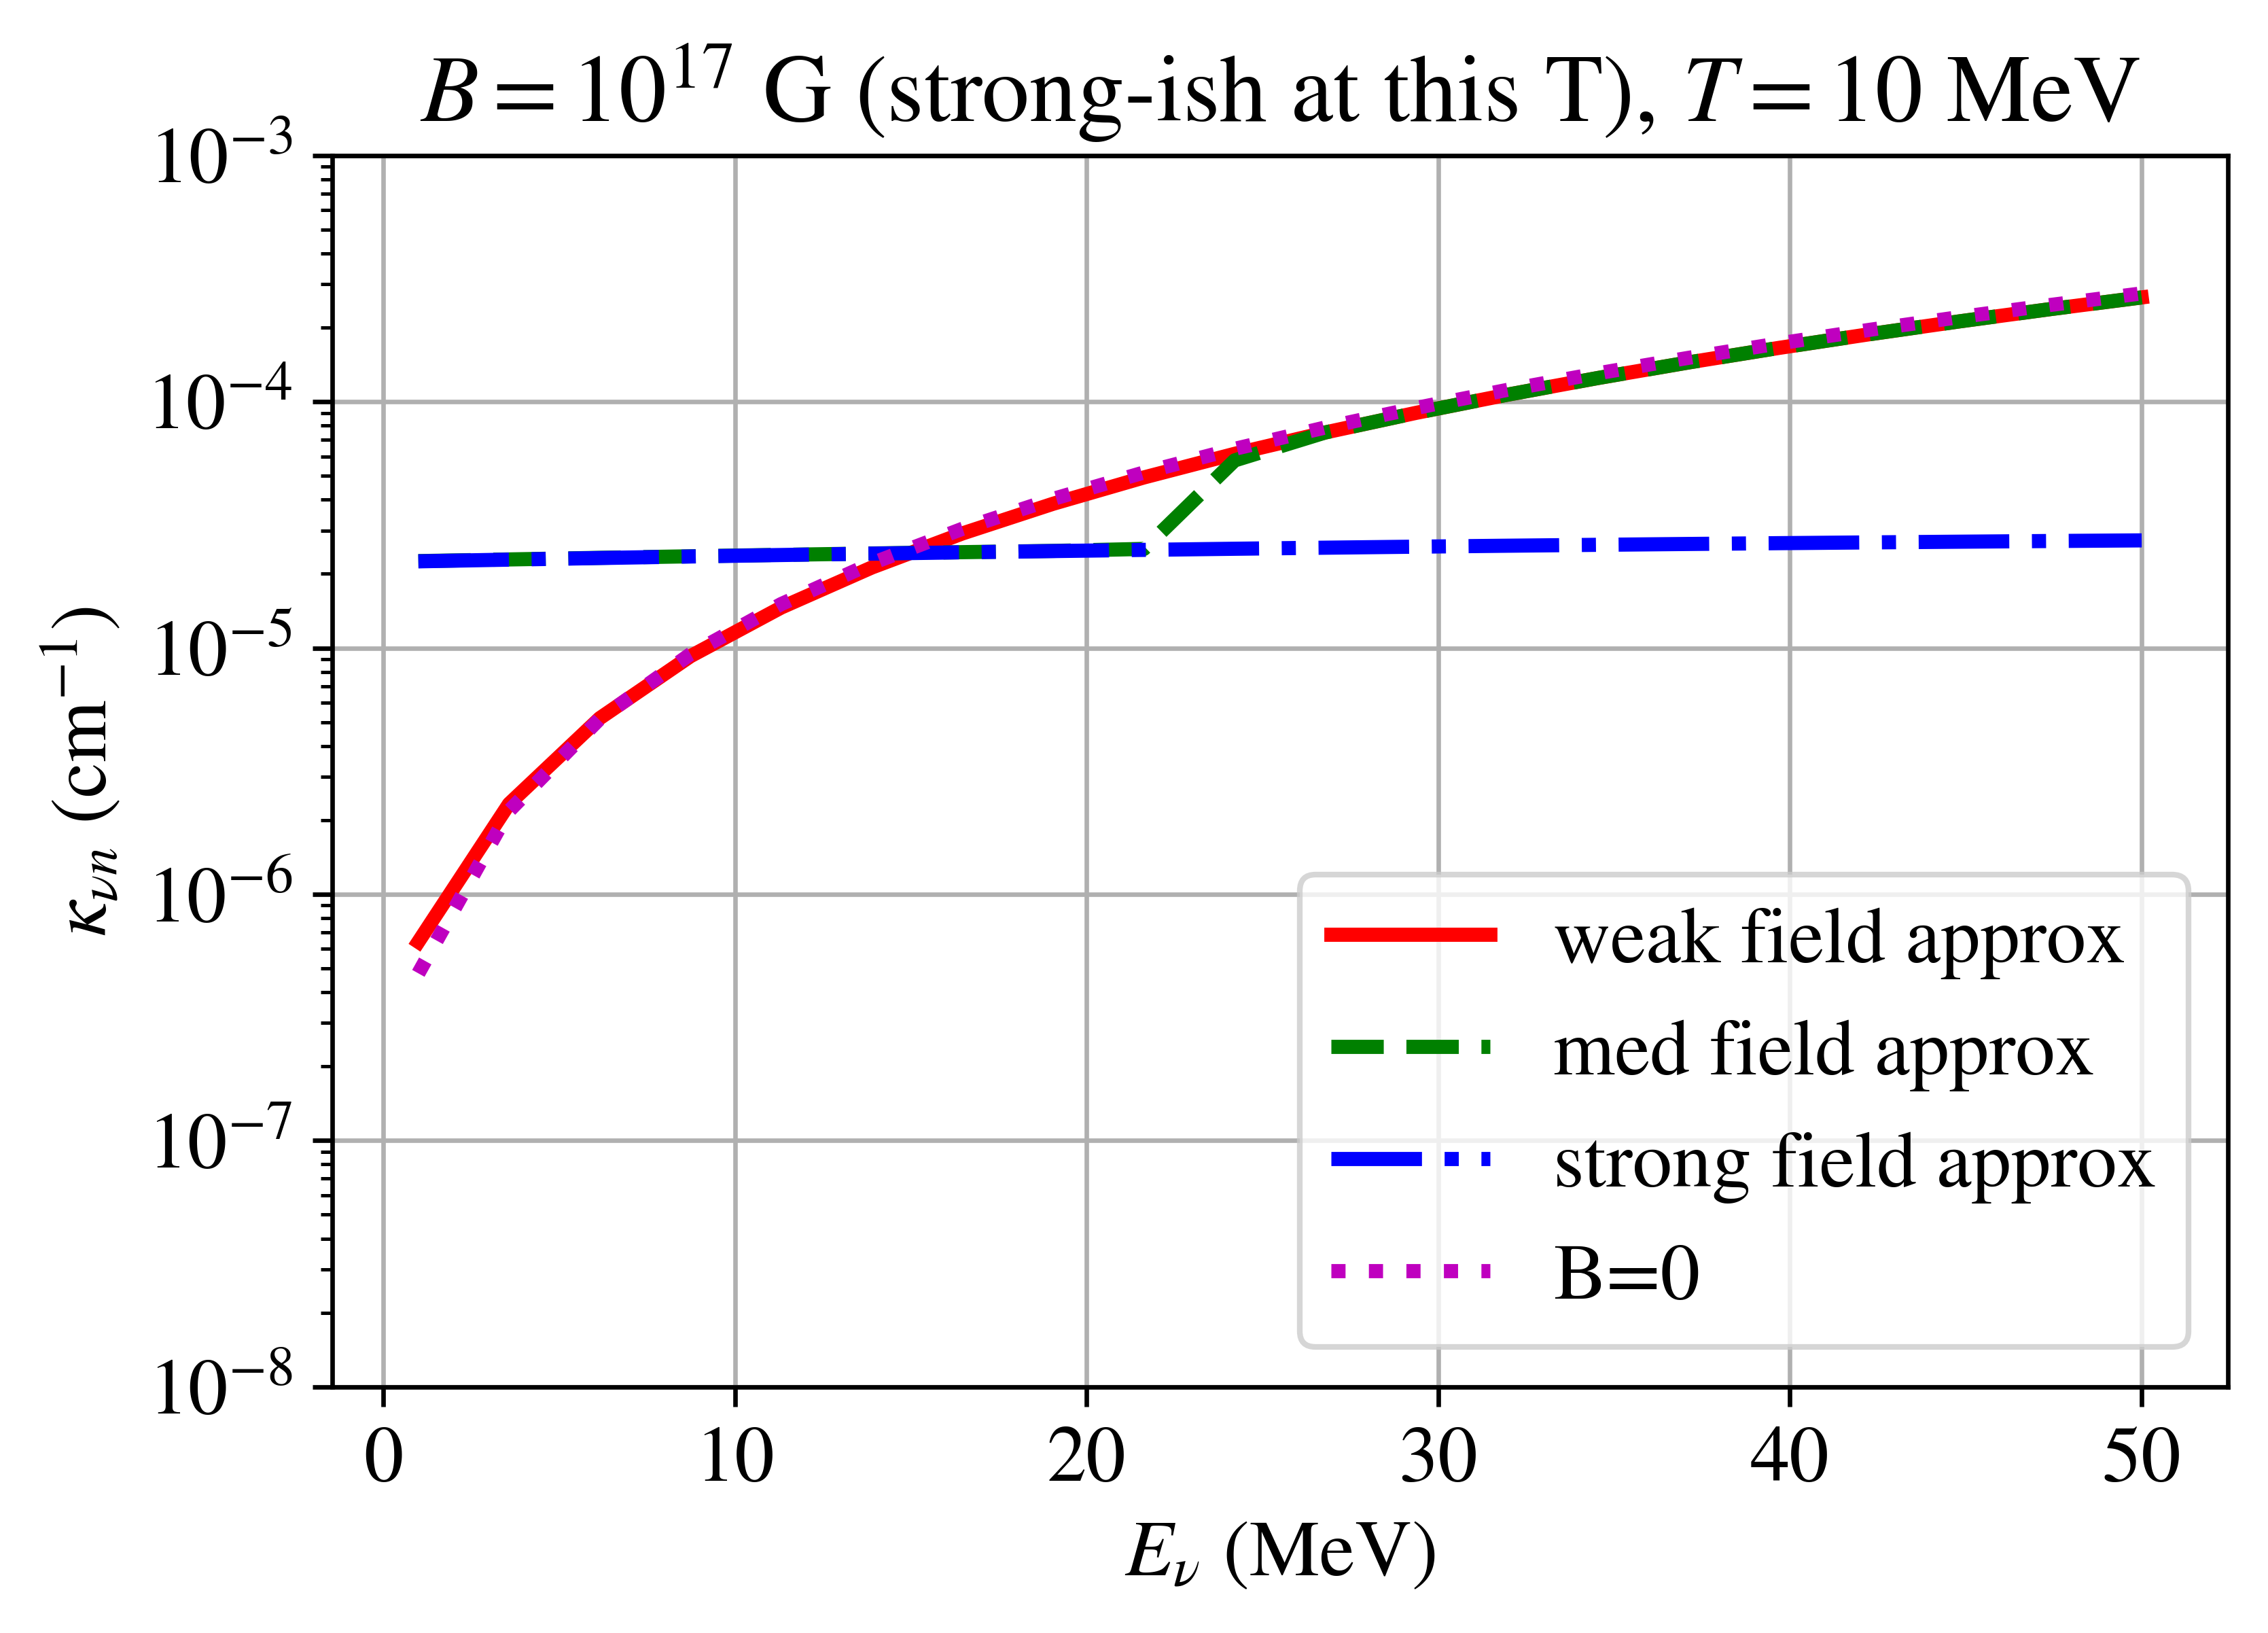

In [79]:
knuspace = linspace(1, 50, 20) / HBARC

plt.plot(knuspace * HBARC, [nun_opacity_low(0.16 * 10**-2, 0.25, 1e17 * G_TO_FM, 40 / HBARC, knu, 0.7) * 10**13 for knu in knuspace], 'r-',
         knuspace * HBARC, [nun_opacity_med(0.16 * 10**-2, 0.25, 1e17 * G_TO_FM, 40 / HBARC, knu, 0.7) * 10**13 for knu in knuspace], 'g--',
         knuspace * HBARC, [nun_opacity_high(0.16 * 10**-2, 0.25, 1e17 * G_TO_FM, 40 / HBARC, knu, 0.7) * 10**13 for knu in knuspace], 'b-.',
         knuspace * HBARC, [nun_opacity_zero(0.16 * 10**-2, 0.25, 40 / HBARC, knu, 0.7) * 10**13 for knu in knuspace], 'm:')
#plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-8, 1e-3])
plt.xlabel('$E_\\nu$ (MeV)')
plt.ylabel('$\kappa_{\\nu n}$ (cm$^{-1}$)')
plt.grid(True)
plt.legend(['weak field approx', 'med field approx', 'strong field approx', 'B=0'])
plt.title('$B = 10^{17}$ G (strong-ish at this T), $T = 10$ MeV')

In [30]:
kappan_comp_3mev = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([9.620698697053828e-42, 1.1679678066802725e-41, 1.2012741599635759e-41, 1.3762456349338368e-41, 1.5000733746970754e-41, 1.7239685458034566e-41, 1.811199445888541e-41, 1.9513174594283932e-41, 2.0506244910408358e-41, 2.138887119920586e-41, 2.2082755999503886e-41, 2.2906394089828734e-41, 2.352956461329258e-41, 2.417830484581144e-41, 2.4922763529919566e-41, 2.607318942363941e-41, 2.828514219132879e-41, 3.299564719726727e-41, 4.2876624058213587e-41, 6.118260617120438e-41])
kappan_comp_1mev = 10**39 * 0.16 * 10**-3 * 0.75 * np.array([7.778990987420739e-45, 3.687426376279251e-44, 1.7570246587074735e-43, 8.058481616902194e-43, 3.247322444995863e-42, 9.648957639008996e-42, 1.8277940635281547e-41, 2.389554329931399e-41, 2.5940367447684583e-41, 2.654844550153016e-41, 2.6674640290705736e-41, 2.667228300794447e-41, 2.6609023397776513e-41, 2.6629424016380714e-41, 2.3720659097910184e-41, 2.2589052802796264e-41, 2.6278444072160873e-41, 2.6488247334664534e-41, 2.662110563180715e-41, 1.7550906787180635e-41])

Text(0.5, 1.0, '$B = 10^{17}$ G, $T = 3$ MeV')

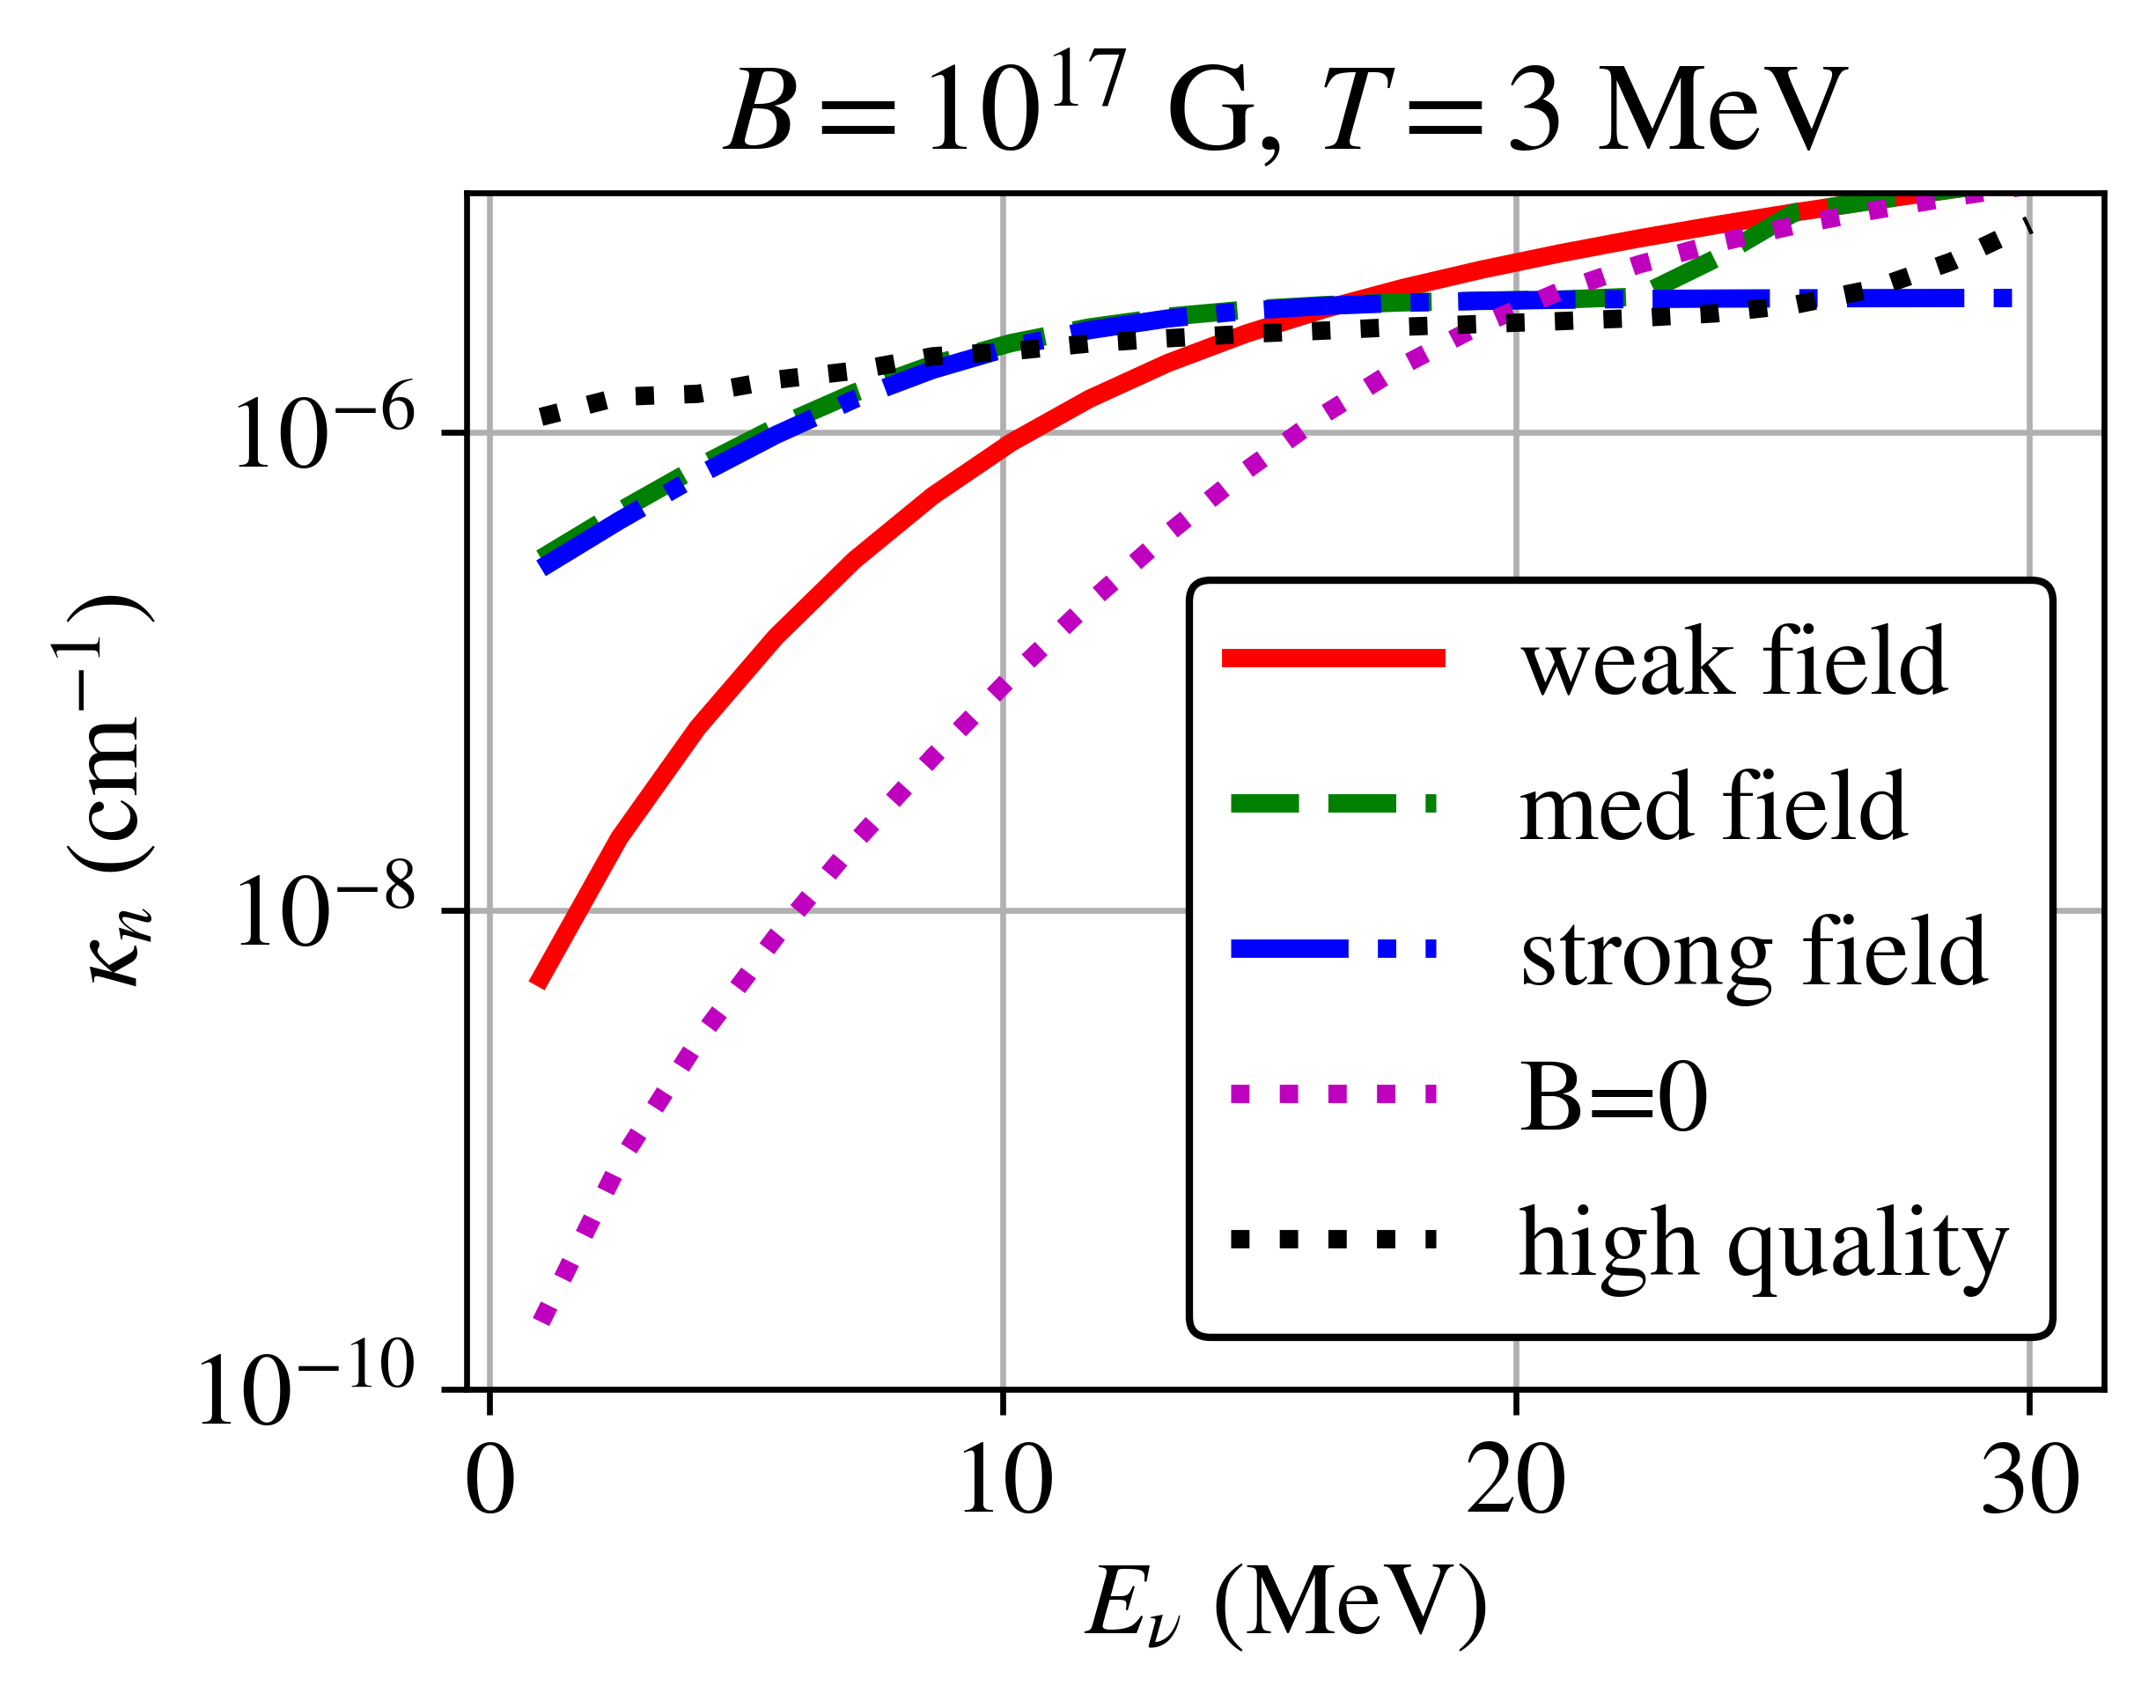

In [70]:
knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (4, 3))

ax_temp.plot(knuspace * HBARC, [nun_opacity_low(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'r-',
        knuspace * HBARC, [nun_opacity_med(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.',
        knuspace * HBARC, [nun_opacity_zero(0.16 * 10**-3, 0.25, 3 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'm:',
        knuspace * HBARC, kappan_comp_3mev, 'k:')
ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)

ax_temp.set_ylim([1e-10, 1e-5])
ax_temp.legend(['weak field', 'med field', 'strong field', 'B=0', 'high quality'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 3$ MeV')

Text(0.5, 1.0, '$B = 10^{17}$ G, $T = 1$ MeV')

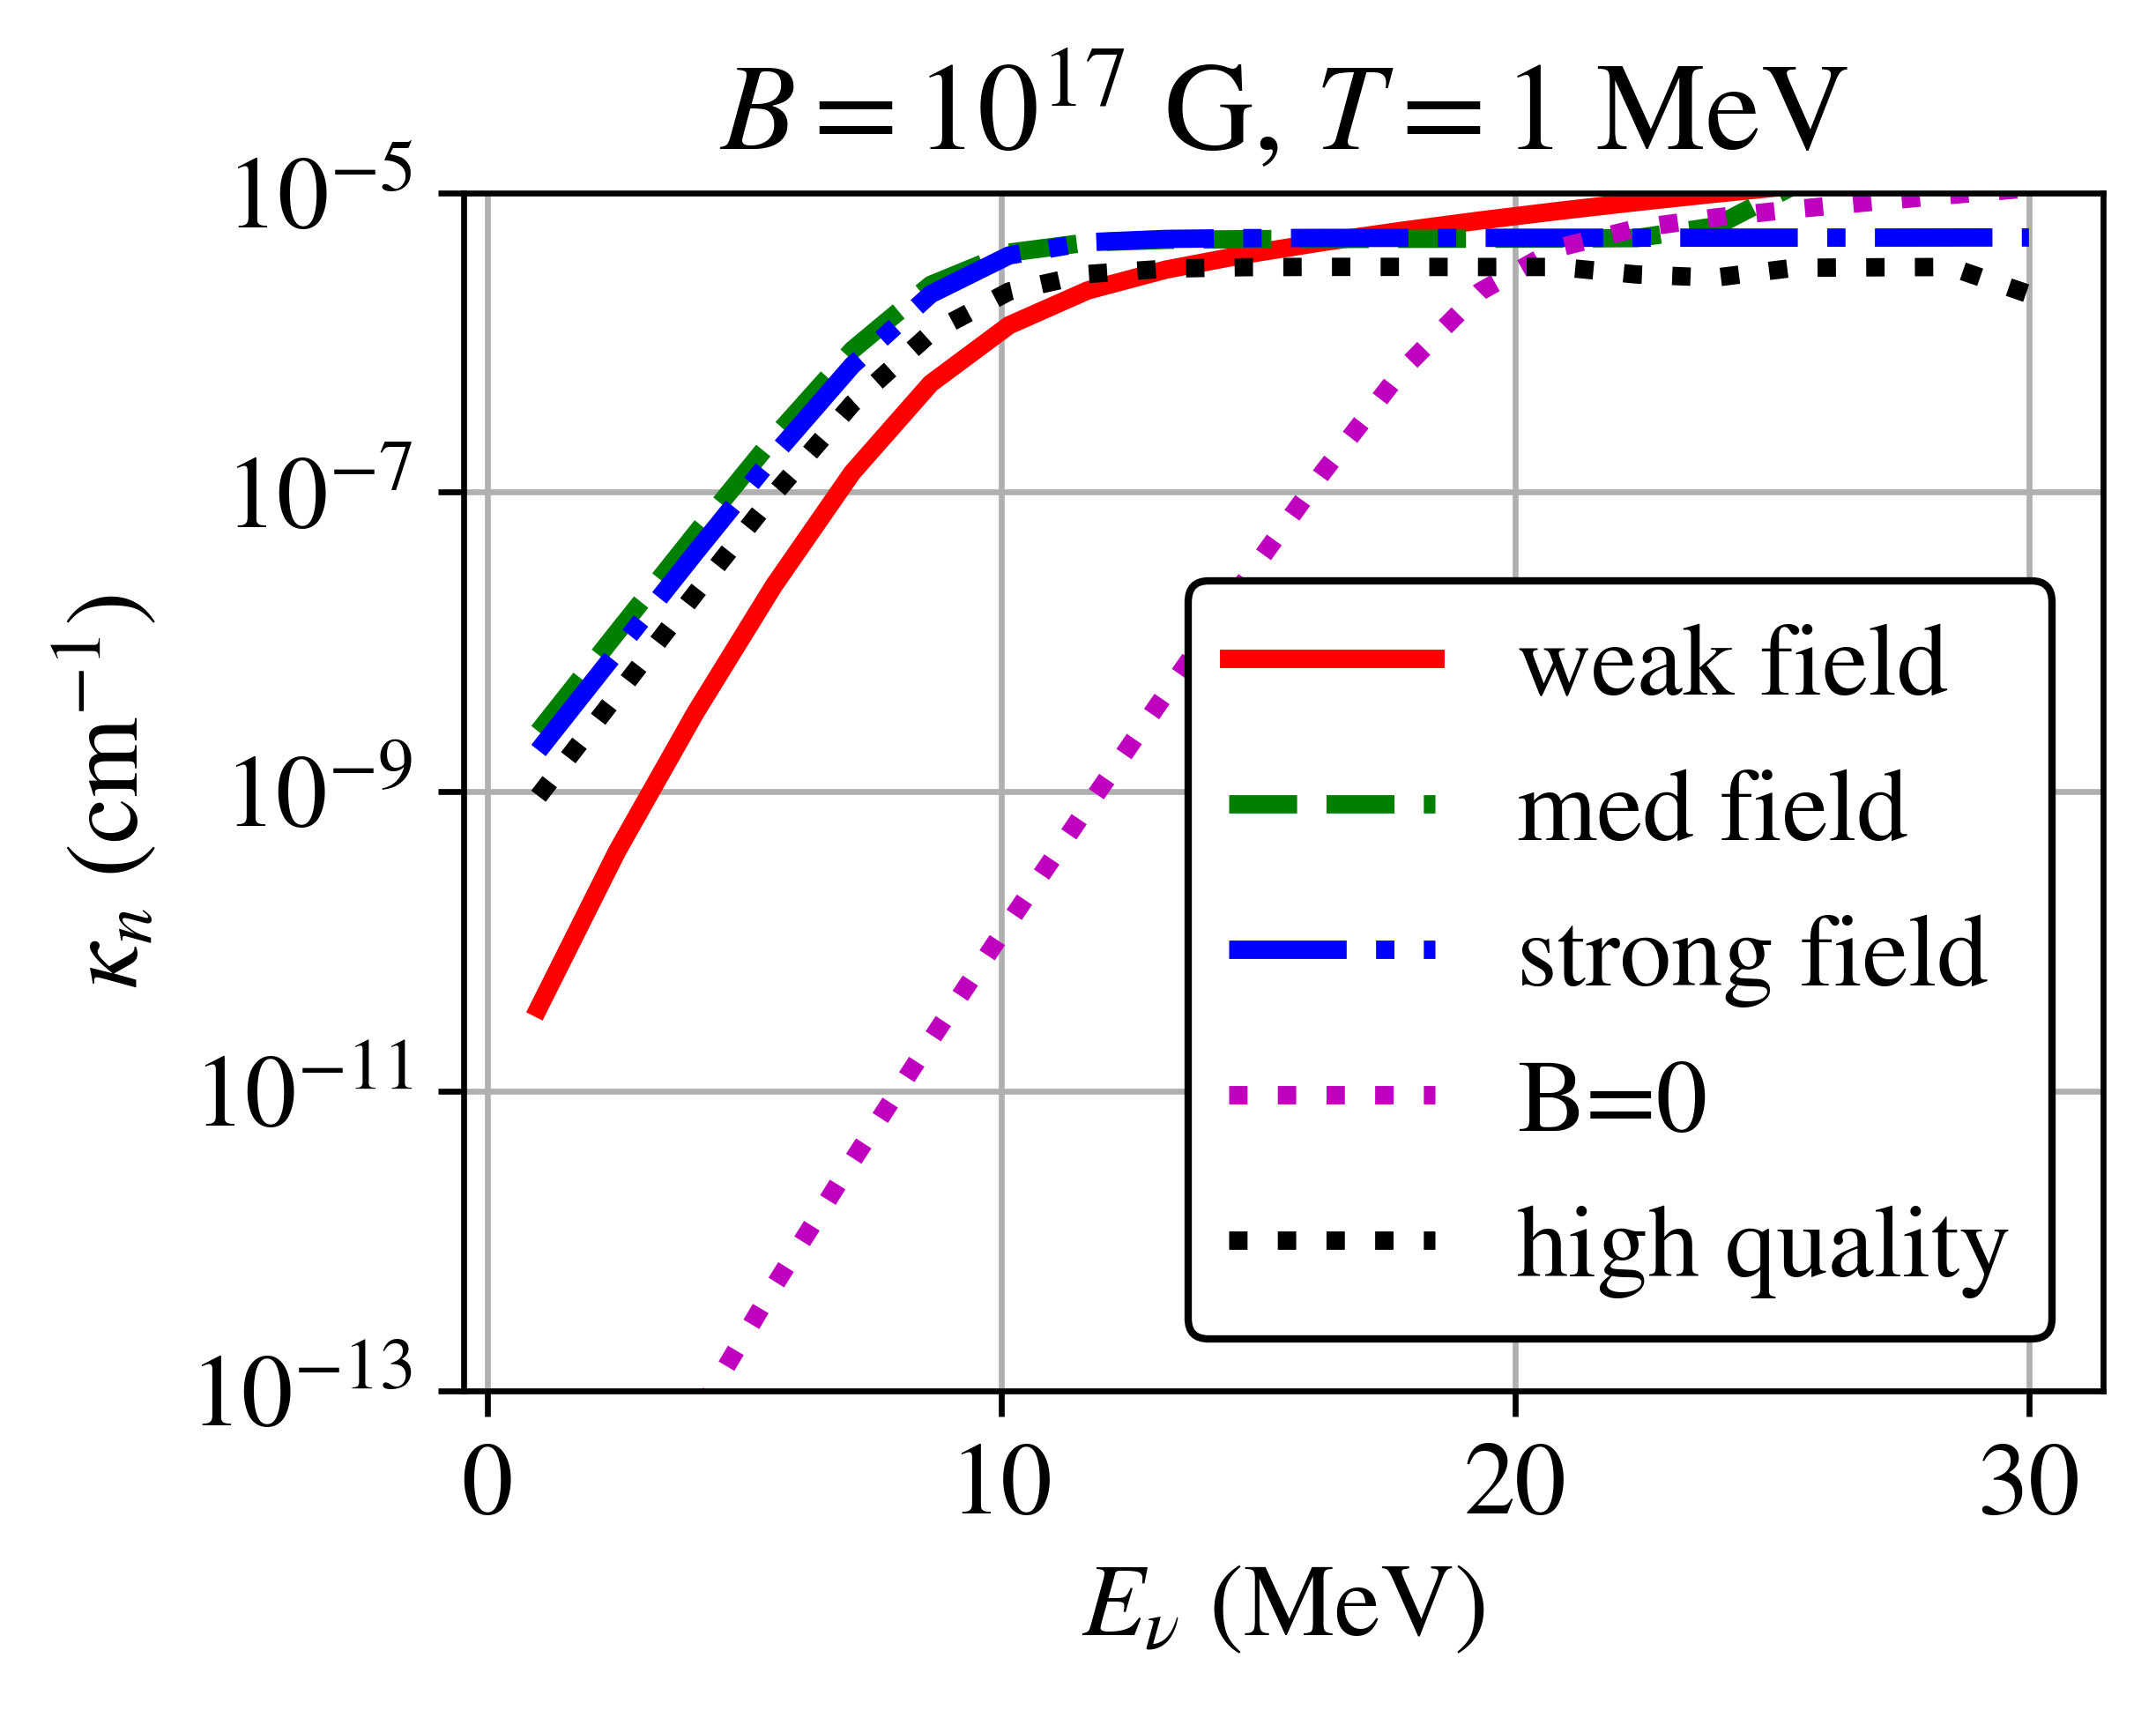

In [69]:
knuspace = linspace(1, 30, 20) / HBARC

fig, ax_temp = plt.subplots(figsize = (4, 3))

ax_temp.plot(knuspace * HBARC, [nun_opacity_low(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'r-',
        knuspace * HBARC, [nun_opacity_med(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'g--',
        knuspace * HBARC, [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'b-.',
        knuspace * HBARC, [nun_opacity_zero(0.16 * 10**-3, 0.25, 1 / HBARC, knu, 0) * 10**13 for knu in knuspace], 'm:',
        knuspace * HBARC, kappan_comp_1mev, 'k:')
ax_temp.set_yscale('log')
ax_temp.set_xlabel('$E_\\nu$ (MeV)')
ax_temp.set_ylabel('$\kappa_n$ (cm$^{-1}$)')
ax_temp.grid(alpha = 1)

ax_temp.set_ylim([1e-13, 1e-5])
ax_temp.legend(['weak field', 'med field', 'strong field', 'B=0', 'high quality'], edgecolor = 'k', framealpha = 1)
ax_temp.set_title('$B = 10^{17}$ G, $T = 1$ MeV')

In [76]:
%prun [nun_opacity_high(0.16 * 10**-3, 0.25, 1e17 * G_TO_FM, 1 / HBARC, knu, 0) * 10**13 for knu in linspace(1 / HBARC, 50 / HBARC, 100)]

         5405223 function calls (5403021 primitive calls) in 17.504 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   466600    7.907    0.000    8.962    0.000 <ipython-input-2-39514f56976d>:22(fermi_dirac)
   466600    2.121    0.000   11.083    0.000 <ipython-input-2-39514f56976d>:35(nfd)
   233100    2.034    0.000   16.949    0.000 <ipython-input-55-01bf0ebd388f>:11(<lambda>)
   233100    1.554    0.000    1.554    0.000 <ipython-input-55-01bf0ebd388f>:1(electron_energy)
   233100    0.882    0.000    0.882    0.000 {method 'reduce' of 'numpy.ufunc' objects}
703303/701101    0.695    0.000    2.638    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   233100    0.428    0.000    1.486    0.000 fromnumeric.py:69(_wrapreduction)
     1100    0.398    0.000   17.347    0.016 {built-in method scipy.integrate._quadpack._qagse}
   466600    0.375    0.000    0.970    0.000 <__array_function__ i

0.005619103976164651